In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from statsmodels.regression.rolling import RollingOLS
import wrds

# Data

In [2]:
IC = pd.read_excel("../data/Total Invested Capital FactSet.xlsx", sheet_name=2)
IC

,Year,Ticker Symbol,NYear,Cash & Short-Term Investments,Total Debt,Total Shareholder Equity,Total Invested Capital (Calculated)
0,1963,AAL,-59,NaN,NaN,NaN,NaN
1,1964,AAL,-58,NaN,NaN,NaN,NaN
2,1965,AAL,-57,NaN,NaN,NaN,NaN
3,1966,AAL,-56,NaN,NaN,NaN,NaN
4,1967,AAL,-55,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
46400,2018,ACA,-4,99.4,185.5,1684.5,1770.6
46401,2019,ACA,-3,240.4,126.3,1790.4,1676.3
46402,2020,ACA,-2,95.8,275.7,1892.2,2072.1
46403,2021,ACA,-1,72.9,703.4,1953.3,2583.8


In [3]:
raw = pd.read_excel("../data/raw.xlsx")
raw

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Industry Format,Level of Consolidation - Company Interim Descriptor,Population Source,Data Format,Ticker Symbol,Company Name,...,Short-Term Investments- Total,Current Liabilities - Total,Liabilities and Stockholders Equity - Total,Net Income (Loss) - Quarterly,Stockholders Equity - Total,Preferred Stock At Carrying Value - Utility,Capital Expenditures,Operating Activities - Net Cash Flow,Active/Inactive Status Marker,Standard Industry Classification Code
0,1045,1970-03-31,1970,1.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,-4.409,NaN,NaN,NaN,NaN,A,4512
1,1045,1970-06-30,1970,2.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,2.708,NaN,NaN,NaN,NaN,A,4512
2,1045,1970-09-30,1970,3.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,2.788,NaN,NaN,NaN,NaN,A,4512
3,1045,1970-12-31,1970,4.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,-27.485,379.022,NaN,NaN,NaN,A,4512
4,1045,1971-03-31,1971,1.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,-24.257,NaN,NaN,NaN,NaN,A,4512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177840,328795,2021-09-30,2021,3.0,INDL,C,D,STD,ACA,ARCOSA INC,...,0.0,389.4,3301.2,23.700,1940.900,NaN,60.8,76.8,A,3440
177841,328795,2021-12-31,2021,4.0,INDL,C,D,STD,ACA,ARCOSA INC,...,0.0,364.0,3188.1,9.200,1953.300,NaN,85.1,166.5,A,3440
177842,328795,2022-03-31,2022,1.0,INDL,C,D,STD,ACA,ARCOSA INC,...,0.0,403.7,3256.8,20.200,1977.600,NaN,25.9,24.5,A,3440
177843,328795,2022-06-30,2022,2.0,INDL,C,D,STD,ACA,ARCOSA INC,...,0.0,416.4,3337.3,39.000,1996.000,NaN,52.9,111.2,A,3440


In [6]:
# for those finance service companies
raw["ave_equity"] = (raw["Stockholders Equity - Total"] +
                     raw["Stockholders Equity - Total"].shift()) * 1/2
raw["ave_asset"] = (raw['Assets - Total'] +
                    raw['Assets - Total'].shift()) * 1/2
raw["ave_equity"] = raw["ave_equity"].replace(0.0, np.nan)
raw["ave_asset"] = raw["ave_asset"].replace(0.0, np.nan)
# raw["NI_chg"] = raw["Net Income (Loss)"].diff().copy()
# raw[raw["Fiscal Quarter"] == 1]["NI_chg"] = raw[raw["Fiscal Quarter"]
#                                                 == 1]["Net Income (Loss)"]

# #####################################
# raw["NI_chg"] = raw["NI_chg"]
raw["ROA"] = raw["Net Income (Loss) - Quarterly"]/raw["ave_asset"]
raw["ROE"] = raw["Net Income (Loss) - Quarterly"]/raw["ave_equity"]

In [11]:
raw['SIC'] = raw['Standard Industry Classification Code'].astype(int)

In [ ]:
raw['SIC'] = raw['Standard Industry Classification Code'].astype(int)
# raw["FCFROIC_ADJ"] = raw["FCFROIC_cal"].copy()
raw.loc[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "FCFROIC_ADJ"] = raw.loc[(
    raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "ROE"]

In [12]:
raw_y = raw[raw["Fiscal Quarter"] == 4].copy()

In [13]:
raw_y["Year"] = raw["Fiscal Year"]

In [14]:
raw_y['Capital Expenditures'] = raw_y['Capital Expenditures'].replace(
    0.0, np.nan)
raw_y["FCF"] = raw_y['Operating Activities - Net Cash Flow'] - \
    raw_y['Capital Expenditures']

In [15]:
IC = IC.merge(raw_y[["Year", "Ticker Symbol", "FCF", "SIC", "ROE"]],
         how="left", on=["Year", "Ticker Symbol"])

In [16]:
IC["avg IC"] = (IC["Total Invested Capital (Calculated)"] + \
    IC["Total Invested Capital (Calculated)"].shift())/2
IC["avg IC"] = IC["avg IC"].replace(0.0, np.nan)
IC["FCFROIC"] = IC["FCF"]/IC["avg IC"]
# financial data
IC.loc[(IC['SIC'] >= 6000) & (IC["SIC"] <= 6411), "FCFROIC_ADJ"] = IC.loc[(
    IC['SIC'] >= 6000) & (IC["SIC"] <= 6411), "ROE"]
IC["FCFROIC"].describe().to_excel("../clean_data/fcfroic_factset_0106.xlsx")

In [61]:
IC["FCFROIC"].describe()

count    29108.000000
mean         0.014373
std          7.709306
min       -836.741573
25%          0.006006
50%          0.074065
75%          0.164167
max        380.904762
Name: FCFROIC, dtype: float64

In [17]:
IC["FCFROIC"].describe()

count    27064.000000
mean         0.009127
std          7.943545
min       -836.741573
25%          0.000773
50%          0.077266
75%          0.173174
max        380.904762
Name: FCFROIC, dtype: float64

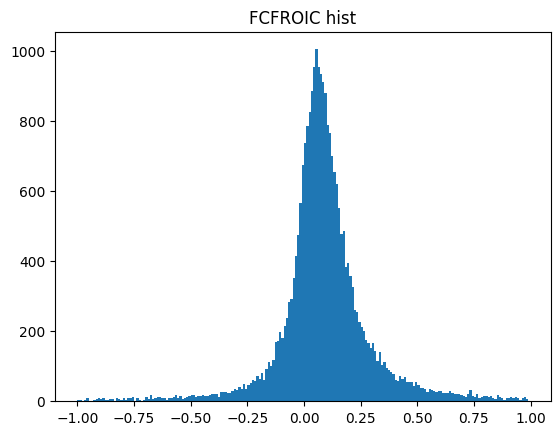

In [18]:
num = IC["FCFROIC"]
plt.hist(num, bins=np.arange(-1, 1, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/FCFROIC hist.png")
plt.show()

In [19]:
grouped = IC.groupby('Ticker Symbol')
FCFROIC_ADJ = pd.DataFrame()
ls = []

for group in grouped:
    group = group[1].iloc[1:].copy()
    group["avg_fcfroic"] = group[["FCFROIC"]].rolling(
        10).mean().fillna(method="ffill")
    group["avg_fcfroic_expanding"] = group[["FCFROIC"]].expanding(
        10).mean().fillna(method="ffill")
    ls.append(group)
    # FCFROIC_ADJ = FCFROIC_ADJ.append(group, ignore_index=True)
FCFROIC_ADJ = pd.concat(ls, ignore_index=True)

In [20]:
FCFROIC_ADJ.to_excel("../clean_data/FCFROIC_ADJ_yearly_0106.xlsx")

In [24]:
FCFROIC_ADJ

,Year,Ticker Symbol,NYear,Cash & Short-Term Investments,Total Debt,Total Shareholder Equity,Total Invested Capital (Calculated),FCF,SIC,ROE,avg IC,FCFROIC,FCFROIC_ADJ,avg_fcfroic,avg_fcfroic_expanding
0,1999,A,-23,789.000,0.0,4171.000,3382.000,27.000,3826.0,NaN,3202.0000,0.008432,NaN,NaN,NaN
1,2000,A,-22,996.000,110.0,5265.000,4379.000,14.000,3826.0,NaN,3880.5000,0.003608,NaN,NaN,NaN
2,2001,A,-21,1170.000,6.0,5659.000,4495.000,621.000,3826.0,NaN,4437.0000,0.139959,NaN,NaN,NaN
3,2002,A,-20,1844.000,1150.0,4627.000,3933.000,-799.000,3826.0,NaN,4214.0000,-0.189606,NaN,NaN,NaN
4,2003,A,-19,1607.000,1150.0,2824.000,2367.000,-349.000,3826.0,NaN,3150.0000,-0.110794,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44741,2022,ZTS,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15971,0.153209
44742,2012,ZU,-10,239.202,0.0,206.487,-32.715,8.425,5961.0,NaN,-24.1625,-0.348681,NaN,NaN,NaN
44743,2013,ZU,-9,308.103,0.0,242.203,-65.900,53.514,5961.0,0.079499,-49.3075,-1.085312,NaN,NaN,NaN
44744,2014,ZU,-8,373.820,0.0,275.963,-97.857,62.257,5961.0,0.040561,-81.8785,-0.760358,NaN,NaN,NaN


In [28]:
FCFROIC_ADJ.groupby("Year").mean().to_excel("../clean_data/yearly_average_fcfroic.xlsx")

/var/folders/4r/0rxnv94550vgr87c0xxxdxm40000gn/T/ipykernel_93541/2722582070.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FCFROIC_ADJ.groupby("Year").mean().to_excel("../clean_data/yearly_average_fcfroic.xlsx")


In [23]:
FCFROIC_ADJ["avg_fcfroic"].describe().to_excel("../clean_data/test.xlsx")

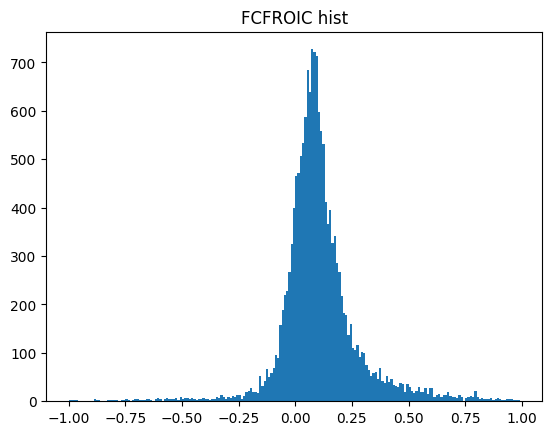

In [22]:
num = FCFROIC_ADJ["avg_fcfroic"]
plt.hist(num, bins=np.arange(-1, 1, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/FCFROIC hist.png")
plt.show()

In [4]:
raw.columns

Index(['Global Company Key', 'Data Date', 'Fiscal Year', 'Fiscal Quarter',
       'Industry Format',
       'Level of Consolidation - Company Interim Descriptor',
       'Population Source', 'Data Format', 'Ticker Symbol', 'Company Name',
       'ISO Currency Code', 'Calendar Data Year and Quarter',
       'Fiscal Data Year and Quarter', 'Assets - Total',
       'Common/Ordinary Equity - Total', 'Cash and Short-Term Investments',
       'Cash', 'Debt in Current Liabilities', 'Long-Term Debt - Total',
       'Invested Capital - Total - Quarterly', 'Short-Term Investments- Total',
       'Current Liabilities - Total',
       'Liabilities and Stockholders Equity - Total', 'Net Income (Loss)',
       'Stockholders Equity - Total',
       'Preferred Stock At Carrying Value - Utility', 'Capital Expenditures',
       'Net Income (Loss).1', 'Operating Activities - Net Cash Flow',
       'Active/Inactive Status Marker',
       'Standard Industry Classification Code'],
      dtype='object')

In [5]:
raw[["Fiscal Year", "Capital Expenditures"]]

,Fiscal Year,Capital Expenditures
0,1970,NaN
1,1970,NaN
2,1970,NaN
3,1970,NaN
4,1971,NaN
...,...,...
177840,2021,60.8
177841,2021,85.1
177842,2022,25.9
177843,2022,52.9


## cal free cash flow

In [8]:
# for companies which do not have Capital Expenditures: nan --> 0

raw["FCF"] = raw['Operating Activities - Net Cash Flow'] - \
    raw['Capital Expenditures']

raw["FCF_diff"] = raw["FCF"].diff()
raw["FCF_annualized"] = raw["FCF_diff"]*4

In [14]:
raw.loc[raw["Fiscal Quarter"] == 1, "FCF_diff"] = raw.loc[raw["Fiscal Quarter"] == 1, "FCF"]
# raw[raw["Ticker Symbol"] == "AAL"][["Data Date", "FCF", "FCF_diff"]]
raw["FCF_annualized"] = raw["FCF_diff"]*4

## cal invested capital

In [16]:
def fillna(df, col_name):
    df[col_name] = df[col_name].fillna(0)
    return df


raw = fillna(raw, "Debt in Current Liabilities")
raw = fillna(raw, "Long-Term Debt - Total")
raw = fillna(raw, "Stockholders Equity - Total")
raw = fillna(raw, 'Cash and Short-Term Investments')

In [17]:
raw["IC_cal"] = raw["Debt in Current Liabilities"] + \
    raw["Long-Term Debt - Total"] + raw['Stockholders Equity - Total'] - \
    raw['Cash and Short-Term Investments']
raw["IC_cal"] = raw["IC_cal"].replace(0.0, np.nan)

<AxesSubplot: >

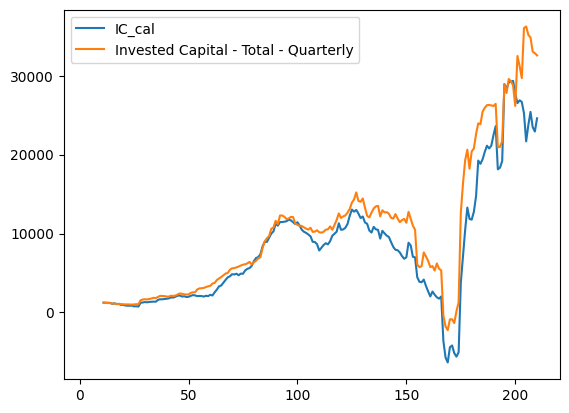

In [18]:
raw[raw["Ticker Symbol"] == "AAL"][[
    "IC_cal", "Invested Capital - Total - Quarterly"]].plot()

In [ ]:
raw[raw["Ticker Symbol"] == "AAL"][[
    "IC_cal", "Invested Capital - Total - Quarterly"]].plot()

In [22]:
raw["pre_IC"] = raw["Invested Capital - Total - Quarterly"].shift()
raw["avg_IC"] = (raw["Invested Capital - Total - Quarterly"] + raw["pre_IC"])/2
raw["FCFROIC"] = raw["FCF_annualized"] / raw["avg_IC"]

In [23]:
raw["pre_IC_cal"] = raw["IC_cal"].shift()
raw["avg_IC_cal"] = (raw["IC_cal"] + raw["pre_IC_cal"])/2
# raw["avg_IC_cal"] = raw["avg_IC_cal"].replace(0.0, np.nan)

raw["FCFROIC_cal"] = raw["FCF_annualized"]/raw["avg_IC_cal"]  # 3

<AxesSubplot: >

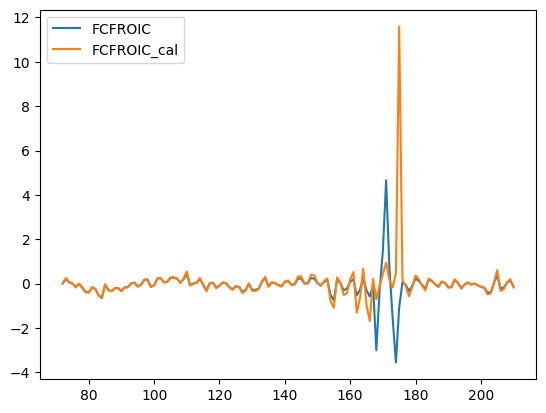

In [24]:
raw[raw["Ticker Symbol"] == "AAL"][[
    "FCFROIC", "FCFROIC_cal"]].plot()

<AxesSubplot: >

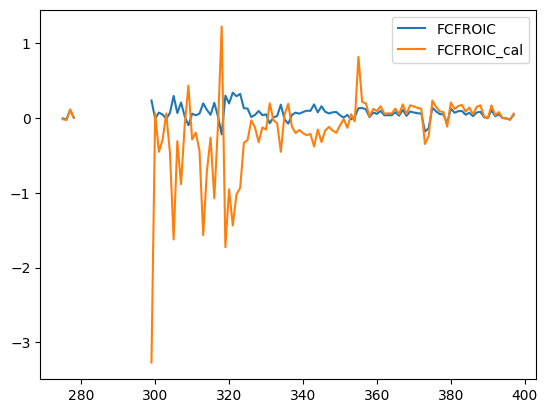

In [25]:
raw[raw["Ticker Symbol"] == "AVX"][[
    "FCFROIC", "FCFROIC_cal"]].plot()

## cal financial industry roe

In [33]:
# for those finance service companies
raw["ave_equity"] = (raw["Stockholders Equity - Total"] +
                     raw["Stockholders Equity - Total"].shift()) * 1/2
raw["ave_asset"] = (raw['Assets - Total'] +
                    raw['Assets - Total'].shift()) * 1/2
raw["ave_equity"] = raw["ave_equity"].replace(0.0, np.nan)
raw["ave_asset"] = raw["ave_asset"].replace(0.0, np.nan)
# raw["NI_chg"] = raw["Net Income (Loss)"].diff().copy()
# raw[raw["Fiscal Quarter"] == 1]["NI_chg"] = raw[raw["Fiscal Quarter"]
#                                                 == 1]["Net Income (Loss)"]

# #####################################
# raw["NI_chg"] = raw["NI_chg"]
raw["ROA"] = raw["Net Income (Loss)"]/raw["ave_asset"]
raw["ROE"] = raw["Net Income (Loss)"]/raw["ave_equity"]

In [34]:
raw['SIC'] = raw['Standard Industry Classification Code'].astype(int)
raw["FCFROIC_ADJ"] = raw["FCFROIC_cal"].copy()
raw.loc[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "FCFROIC_ADJ"] = raw.loc[(
    raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "ROE"]

In [35]:
fcfroic = raw[["Fiscal Year", "Fiscal Quarter",
               "Ticker Symbol", "Debt in Current Liabilities", "Long-Term Debt - Total", "Stockholders Equity - Total", "Cash and Short-Term Investments", 
               "IC_cal", "Invested Capital - Total - Quarterly",
               "FCF", "FCF_annualized", "FCFROIC", "FCFROIC_cal", 
               "ROE", "FCFROIC_ADJ", 
               "Standard Industry Classification Code"]]
fcfroic.to_excel("../clean_data/fcfroic/fcfroic_1216_add.xlsx")

# functions

In [ ]:
def rmv_outliner(data, method="3sigma", lo_q=0.01, hi_q=0.99, fill="delete"):
    '''
    remove outliner
    '''
    if method == "3sigma":
        _h = data.mean() + 3*data.std()
        _l = data.mean() - 3*data.std()
    elif method == "quantile":
        q = data.quantile([lo_q, hi_q])
        _l = q.iloc[0]
        _h = q.iloc[1]

    if fill == "delete":
        for colname in data.columns:
            data = data.copy()
            data = data[(data[colname] < _h[colname]) &
                        (data[colname] > _l[colname])]

    return data

# Calculation

In [ ]:
# # average invested capital
# raw["pre_IC"] = raw["Invested Capital - Total - Quarterly"].shift()
# raw["ave_IC"] = (
#     raw["Invested Capital - Total - Quarterly"] + raw["pre_IC"]) * 1/2
# raw["IC_diff"] = raw["Invested Capital - Total - Quarterly"] - raw["pre_IC"]

# # for companies which do not have Capital Expenditures: nan --> 0
# # raw[raw['Capital Expenditures'] == np.nan] = 0
# raw["FCF"] = raw['Operating Activities - Net Cash Flow'] - \
#     raw['Capital Expenditures']

# raw['Capital Expenditures'] = raw['Capital Expenditures'].fillna(0)
# raw["FCF_fillna"] = raw['Operating Activities - Net Cash Flow'] - \
#     raw['Capital Expenditures']

# raw["FCFROIC"] = raw["FCF"]/raw["ave_IC"]  ## 1
# raw["FCFROIC_fillna"] = raw["FCF_fillna"]/raw["ave_IC"]  ## 2
# # Common/Ordinary Equity - Total
# # Investment and Advances - Equity
# raw["IC_cal"] = raw["Current Liabilities - Total"] + raw["Long-Term Debt - Total"] - raw["Cash"]
     
# raw["pre_IC_cal"] = raw["IC_cal"].shift()
# raw["avg_IC_cal"] = (raw["IC_cal"] + raw["pre_IC_cal"])/2

# raw["FCFROIC_cal"] = raw["FCF_fillna"]/raw["avg_IC_cal"]  # 3

# # for those finance service companies
# raw["ave_equity"] = (raw["Stockholders Equity - Total"] +
#                      raw["Stockholders Equity - Total"].shift()) * 1/2
# raw["ave_asset"] = (raw['Assets - Total'] +
#                     raw['Assets - Total'].shift()) * 1/2

# raw["NI_chg"] = raw["Net Income (Loss)"].diff().copy()
# raw[raw["Fiscal Quarter"] == 1]["NI_chg"] = raw[raw["Fiscal Quarter"]
#                                                 == 1]["Net Income (Loss)"]

# #####################################
# raw["NI_chg"] = raw["NI_chg"]
# raw["ROA"] = raw["NI_chg"]/raw["ave_asset"]
# raw["ROE"] = raw["NI_chg"]/raw["ave_equity"]

In [ ]:
# # finance industry: SIC code 6000-6411
# raw['SIC'] = raw['Standard Industry Classification Code'].astype(int)
# raw["FCFROIC_ADJ"] = raw["FCFROIC_cal"].copy()
# raw.loc[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "FCFROIC_ADJ"] = raw.loc[(
#     raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "ROE"]

In [36]:
grouped = raw.groupby('Global Company Key')
FCFROIC_ADJ = pd.DataFrame(columns=["Global Company Key", "Data Date",
                                    "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC_ADJ", "avg_fcfroic", "avg_fcfroic_expanding"])
ls = []
for group in grouped:
    group = group[1].iloc[1:][["Global Company Key", "Data Date",
                               "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC_ADJ"]].copy()
    group["avg_fcfroic"] = group[["FCFROIC_ADJ"]].rolling(
        40).mean().fillna(method="ffill")
    group["avg_fcfroic_expanding"] = group[["FCFROIC_ADJ"]].expanding(
        40).mean().fillna(method="ffill")
    ls.append(group)
    # FCFROIC_ADJ = FCFROIC_ADJ.append(group, ignore_index=True)
FCFROIC_ADJ = pd.concat(ls, ignore_index=True)

In [37]:
FCFROIC_ADJ[["avg_fcfroic", "avg_fcfroic_expanding"]].describe()

,avg_fcfroic,avg_fcfroic_expanding
count,70887.000000,72911.000000
mean,0.155520,0.229891
std,4.718144,6.148953
min,-48.707581,-86.772637
25%,-0.010504,-0.061064
50%,0.069325,0.058317
75%,0.183823,0.191997
max,259.128843,259.089874


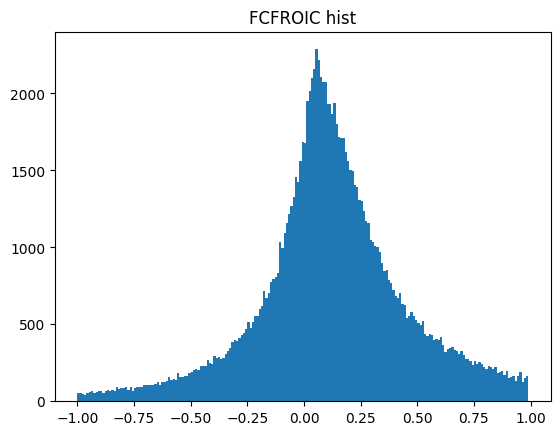

In [20]:
num = FCFROIC_ADJ["FCFROIC_cal"]
plt.hist(num, bins=np.arange(-1, 1, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/FCFROIC hist.png")
plt.show()

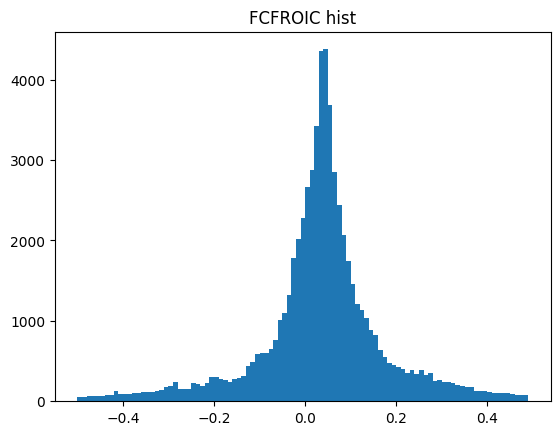

In [ ]:
num = FCFROIC_ADJ["avg_fcfroic"]
plt.hist(num, bins=np.arange(-0.5, 0.5, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/10y average FCFROIC hist.png")
plt.show()

/var/folders/4r/0rxnv94550vgr87c0xxxdxm40000gn/T/ipykernel_81899/3819934405.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  his_mean = FCFROIC_ADJ.groupby("Data Date").mean()


<AxesSubplot: xlabel='Data Date'>

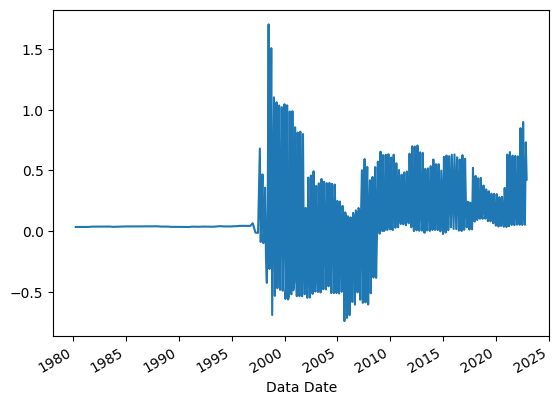

In [31]:
his_mean = FCFROIC_ADJ.groupby("Data Date").mean()
his_mean["avg_fcfroic"].dropna().plot()

<AxesSubplot: xlabel='Data Date'>

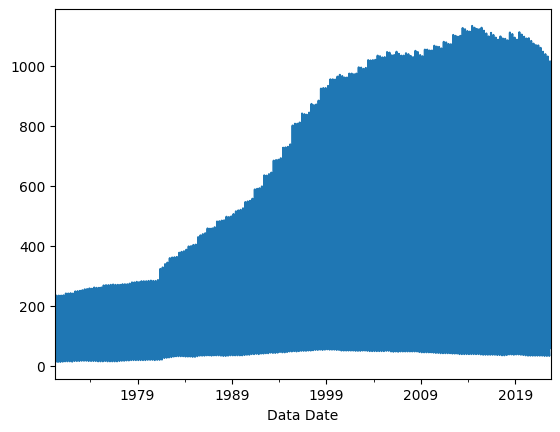

In [ ]:
his_num = FCFROIC_ADJ.groupby("Data Date").count()
his_num["Global Company Key"].dropna().plot()

In [38]:
FCFROIC_ADJ.to_excel("../clean_data/FCFROIC_ADJ_1217.xlsx")

In [ ]:
FCFROIC_ADJ

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC_cal,avg_fcfroic,avg_fcfroic_expanding
0,1045,1970-06-30,1970,2.0,AAL,NaN,NaN,NaN
1,1045,1970-09-30,1970,3.0,AAL,NaN,NaN,NaN
2,1045,1970-12-31,1970,4.0,AAL,NaN,NaN,NaN
3,1045,1971-03-31,1971,1.0,AAL,NaN,NaN,NaN
4,1045,1971-06-30,1971,2.0,AAL,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
176166,328795,2021-09-30,2021,3.0,ACA,0.006215,NaN,NaN
176167,328795,2021-12-31,2021,4.0,ACA,0.031091,NaN,NaN
176168,328795,2022-03-31,2022,1.0,ACA,-0.000541,NaN,NaN
176169,328795,2022-06-30,2022,2.0,ACA,0.022172,NaN,NaN
